In [1]:
import pandas as pd
import numpy as np
import requests
import datetime

In [2]:
# Get Data from SpaceX
spacex_url="https://api.spacexdata.com/v4/launches/past"
past = requests.get(spacex_url)
past.status_code

200

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

past_df = pd.json_normalize(past.json())

past_df.shape

(186, 43)

In [7]:
data = past_df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

data = data[data['payloads'].map(len)==1]
data = data[data['cores'].map(len)==1]

data['payloads'] = data['payloads'].map(lambda x : x[0])
data['cores'] = data['cores'].map(lambda x : x[0])

data['date'] = pd.to_datetime(data['date_utc']).dt.date

data = data[data['date'] <= datetime.date(2020, 11, 13)]

#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [8]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])
        
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])   
        
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])    
        
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])        

In [9]:
# Call getBoosterVersion
getBoosterVersion(data)

# Call getLaunchSite
getLaunchSite(data)

# Call getPayloadData
getPayloadData(data)

# Call getCoreData
getCoreData(data)

In [10]:
BV = []
for x in data['rocket']:
    response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
    BV.append(response['name'])
    
len(BV)

94

In [11]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BV,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [12]:
final = pd.DataFrame.from_dict(launch_dict)

final_9 = final[final['BoosterVersion'] == 'Falcon 9']

final_9.loc[:,'FlightNumber'] = list(range(1, final_9.shape[0]+1))

/var/folders/7k/gnl2tlcd2l9drj6rf4mgnx3r0000gn/T/ipykernel_29986/4223381091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_9.loc[:,'FlightNumber'] = list(range(1, final_9.shape[0]+1))


In [13]:
final_9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [14]:
final_9['PayloadMass'] = final_9['PayloadMass'].replace(np.nan,final['PayloadMass'].mean())

final_9.to_csv('dataset_part_1.csv', index=False)

/var/folders/7k/gnl2tlcd2l9drj6rf4mgnx3r0000gn/T/ipykernel_29986/2361390742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_9['PayloadMass'] = final_9['PayloadMass'].replace(np.nan,final['PayloadMass'].mean())


## Next Step: Webscrapping from Wikipedia

In [15]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

In [16]:
wiki_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
wiki_raw = requests.get(wiki_url).text
wiki = BeautifulSoup(wiki_raw, 'html5lib')
wiki

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en"><head>
<meta charset="utf-8"/>
<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"715971b9-8c49-4355-a4ab-e6619c45f552","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_Falcon_9_and_Falcon_Heavy_launches","wgTitle":"List of Falcon 9 and Falcon Heavy launches","wgCurRevisionId":1113846261,"wgRevisionId":1027686922,"wgArticleId":37574004,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Source attribution","All articles with dead external links","Artic

In [17]:
html_tables = wiki.find_all('table')

In [18]:
html_tables[2]

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
<tr>
<th rowspan="2" scope="row" style="text-align:center;">1
</th>
<td>

In [19]:
columns = []
for i in range (len(html_tables[2].find_all('th'))-7):
    string = html_tables[2].find_all('th')[i].text
    columns.append(string[0:-1])
columns

['Flight No.',
 'Date andtime (UTC)',
 'Version,Booster [b]',
 'Launch site',
 'Payload[c]',
 'Payload mass',
 'Orbit',
 'Customer',
 'Launchoutcome',
 'Boosterlanding']

In [20]:
launch_dict= dict.fromkeys(columns)

# Remove an irrelvant column
del launch_dict['Date andtime (UTC)']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Version,Booster [b]']=[]
launch_dict['Launch site'] = []
launch_dict['Payload[c]'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launchoutcome'] = []
launch_dict['Boosterlanding']=[]
# Added some new columns
launch_dict['Date']=[]
launch_dict['Time']=[]

In [21]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


In [22]:
wiki_df = pd.DataFrame(launch_dict)

extracted_row = 0
#Extract each table 
for table_number,table in enumerate(wiki.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            #print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            #print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            #print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            #print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            #print(payload)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            #print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            customer = row[6].text
            #print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            #print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            #print(booster_landing)
            wiki_df = wiki_df.append({"Flight No.":flight_number, "Date":date, "Time":time, "Version,Booster [b]":bv, "Launch site":launch_site, "Payload[c]":payload, "Payload mass":payload_mass, "Orbit":orbit
                                             , "Customer":customer, "Launchoutcome":launch_outcome, "Boosterlanding":booster_landing}, ignore_index=True)

F9 v1.0B0003.1
F9 v1.0B0004.1
F9 v1.0B0005.1
F9 v1.0B0006.1
F9 v1.0B0007.1
F9 v1.1B1003
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 FT
F9 v1.1
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT♺
F9 FT
F9 FT
F9 FT
F9 FTB1029.2
F9 FT
F9 FT
F9 B4
F9 FT
F9 B4
F9 B4
F9 FTB1031.2
F9 B4
F9 FTB1035.2
F9 FTB1036.2
F9 B4
F9 FTB1032.2
F9 FTB1038.2
F9 B4
F9 B4B1041.2
F9 B4B1039.2
F9 B4
F9 B5B1046.1
F9 B4B1043.2
F9 B4B1040.2
F9 B4B1045.2
F9 B5
F9 B5B1048
F9 B5B1046.2
F9 B5
F9 B5B1048.2
F9 B5B1047.2
F9 B5B1046.3
F9 B5
F9 B5
F9 B5B1049.2
F9 B5B1048.3
F9 B5[268]
F9 B5
F9 B5B1049.3
F9 B5B1051.2
F9 B5B1056.2
F9 B5B1047.3
F9 B5
F9 B5
F9 B5B1056.3
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5B1058.2
F9 B5
F9 B5B1049.6
F9 B5
F9 B5B1060.2
F9 B5B1058.3
F9 B5B1051.6
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5
F9 B5B1051.8
F9 B5B1058.5
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5B1060.6
F9

/var/folders/7k/gnl2tlcd2l9drj6rf4mgnx3r0000gn/T/ipykernel_29986/3254197577.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wiki_df = wiki_df.append({"Flight No.":flight_number, "Date":date, "Time":time, "Version,Booster [b]":bv, "Launch site":launch_site, "Payload[c]":payload, "Payload mass":payload_mass, "Orbit":orbit
/var/folders/7k/gnl2tlcd2l9drj6rf4mgnx3r0000gn/T/ipykernel_29986/3254197577.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wiki_df = wiki_df.append({"Flight No.":flight_number, "Date":date, "Time":time, "Version,Booster [b]":bv, "Launch site":launch_site, "Payload[c]":payload, "Payload mass":payload_mass, "Orbit":orbit
/var/folders/7k/gnl2tlcd2l9drj6rf4mgnx3r0000gn/T/ipykernel_29986/3254197577.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [23]:
wiki_df

,Flight No.,"Version,Booster [b]",Launch site,Payload[c],Payload mass,Orbit,Customer,Launchoutcome,Boosterlanding,Date,Time
0,1,F9 v1.0B0003.1,CCAFS,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX\n,Success\n,Failure,4 June 2010,18:45
1,2,F9 v1.0B0004.1,CCAFS,Dragon,0.0,LEO,\nNASA (COTS)\nNRO\n\n,Success,Failure,8 December 2010,15:43
2,3,F9 v1.0B0005.1,CCAFS,Dragon,525 kg,LEO,NASA (COTS)\n,Success,No attempt\n,22 May 2012,07:44
3,4,F9 v1.0B0006.1,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA (CRS)\n,Success\n,No attempt,8 October 2012,00:35
4,5,F9 v1.0B0007.1,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA (CRS)\n,Success\n,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,F9 B5B1051.10,CCSFS,Starlink,"15,600 kg",LEO,SpaceX\n,Success\n,Success,9 May 2021,06:42
117,118,F9 B5B1058.8,KSC,Starlink,"~14,000 kg",LEO,SpaceX Capella Space and Tyvak\n,Success\n,Success,15 May 2021,22:56
118,119,F9 B5B1063.2,CCSFS,Starlink,"15,600 kg",LEO,SpaceX\n,Success\n,Success,26 May 2021,18:59
119,120,F9 B5B1067.1,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA (CRS)\n,Success\n,Success,3 June 2021,17:29


In [24]:
wiki_df.to_csv('spacex_web_scraped.csv', index=False)

In [25]:
wiki_df.isnull().sum()*100

Flight No.             0
Version,Booster [b]    0
Launch site            0
Payload[c]             0
Payload mass           0
Orbit                  0
Customer               0
Launchoutcome          0
Boosterlanding         0
Date                   0
Time                   0
dtype: int64

## Data Wrangling

In [26]:
((final_9.isnull().sum())/(final_9.count()))*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

In [27]:
final_9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [28]:
final_9['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [29]:
final_9['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [30]:
landing_outcomes = final_9['Outcome'].value_counts()

In [31]:
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [32]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [33]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [34]:
outcome

'False RTLS'

In [35]:
landing_class = []
for j in final_9['Outcome']:
    if j in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

final_9['Class']=landing_class
final_9[['Class']].head(8)

/var/folders/7k/gnl2tlcd2l9drj6rf4mgnx3r0000gn/T/ipykernel_29986/3090584779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_9['Class']=landing_class


,Class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1


In [36]:
final_9["Class"].mean()

0.6666666666666666

In [37]:
final_9.to_csv("dataset_part_2.csv", index=False)

## EDA with SQL

In [38]:
!pip install sqlalchemy==1.3.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 446.7 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for sqlalchemy, since package 'wheel' is not installed.
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.3.24
    Uninstalling SQLAlchemy-1.3.24:
      Successfully uninstalled SQLAlchemy-1.3.24
  Running setup.py install for sqlalchemy ... done


In [39]:
!pip install sql

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for sql, since package 'wheel' is not installed.
  Running setup.py install for sql ... done


In [40]:
%load_ext sql
import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

In [41]:
%sql sqlite:///my_data1.db

In [43]:
import pandas as pd
df = pd.read_csv("/Users/ulric/Desktop/Ulric/DS/Excercise Files/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [46]:
%sql SELECT * FROM SPACEXTBL

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing _Outcome
04-06-2010,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
08-12-2010,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
22-05-2012,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
08-10-2012,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
01-03-2013,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
29-09-2013,16:00:00,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500,Polar LEO,MDA,Success,Uncontrolled (ocean)
03-12-2013,22:41:00,F9 v1.1,CCAFS LC-40,SES-8,3170,GTO,SES,Success,No attempt
06-01-2014,22:06:00,F9 v1.1,CCAFS LC-40,Thaicom 6,3325,GTO,Thaicom,Success,No attempt
18-04-2014,19:25:00,F9 v1.1,CCAFS LC-40,SpaceX CRS-3,2296,LEO (ISS),NASA (CRS),Success,Controlled (ocean)
14-07-2014,15:15:00,F9 v1.1,CCAFS LC-40,OG2 Mission 1 6 Orbcomm-OG2 satellites,1316,LEO,Orbcomm,Success,Controlled (ocean)


In [47]:
%sql select distinct(Launch_Site) from SPACEXTBL

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [49]:
%sql select * from SPACEXTBL where Launch_Site Like "CCA%" LIMIT 5

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing _Outcome
04-06-2010,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
08-12-2010,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
22-05-2012,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
08-10-2012,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
01-03-2013,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [50]:
%sql select sum(PAYLOAD_MASS__KG_) from SPACEXTBL where Customer = 'NASA (CRS)'

 * sqlite:///my_data1.db
Done.


sum(PAYLOAD_MASS__KG_)
45596


In [53]:
%sql select avg(PAYLOAD_MASS__KG_) from SPACEXTBL where Booster_Version = 'F9 v1.1'

 * sqlite:///my_data1.db
Done.


avg(PAYLOAD_MASS__KG_)
2928.4


In [54]:
%sql select min(Date) from SPACEXTBL where Mission_Outcome = 'Success'

 * sqlite:///my_data1.db
Done.


min(Date)
01-03-2013


In [55]:
%sql select distinct(Booster_Version) from SPACEXTBL where Mission_Outcome = 'Success' and PAYLOAD_MASS__KG_ between 4000 and 6000

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 v1.1
F9 v1.1 B1011
F9 v1.1 B1014
F9 v1.1 B1016
F9 FT B1020
F9 FT B1022
F9 FT B1026
F9 FT B1030
F9 FT B1021.2
F9 FT B1032.1


In [65]:
%sql select Mission_Outcome, count(1) from SPACEXTBL group by Mission_Outcome

 * sqlite:///my_data1.db
Done.


Mission_Outcome,count(1)
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


In [68]:
%sql select distinct(Booster_Version) from SPACEXTBL where PAYLOAD_MASS__KG_ = (select max(PAYLOAD_MASS__KG_) from SPACEXTBL)

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [71]:
%sql SELECT TO_CHAR(TO_DATE(MONTH("DATE"), 'MM'), 'MONTH') AS MONTH_NAME, \
    LANDING__OUTCOME AS LANDING__OUTCOME, \
    BOOSTER_VERSION AS BOOSTER_VERSION, \
    LAUNCH_SITE AS LAUNCH_SITE \
    FROM SPACEXTBL WHERE LANDING__OUTCOME = 'Failure (drone ship)' AND "DATE" LIKE '%2015%'

 * sqlite:///my_data1.db
(sqlite3.OperationalError) no such function: MONTH
[SQL: SELECT TO_CHAR(TO_DATE(MONTH("DATE"), 'MM' ), 'MONTH' ) AS MONTH_NAME, LANDING__OUTCOME AS LANDING__OUTCOME, BOOSTER_VERSION AS BOOSTER_VERSION, LAUNCH_SITE AS LAUNCH_SITE FROM SPACEXTBL WHERE LANDING__OUTCOME = 'Failure (drone ship)' AND "DATE" LIKE '%2015%']
(Background on this error at: http://sqlalche.me/e/e3q8)


In [78]:
%sql SELECT "Date", COUNT(Landing_Outcome) as COUNT FROM SPACEXTBL \
    WHERE "Date" BETWEEN '2010-06-04' and '2017-03-20' AND Landing_Outcome = '%Success%' \
    GROUP BY "DATE" \
    ORDER BY COUNT(Landing_Outcome) DESC

 * sqlite:///my_data1.db
(sqlite3.OperationalError) no such column: Landing_Outcome
[SQL: SELECT "Date" , COUNT(Landing_Outcome) as COUNT FROM SPACEXTBL WHERE "Date" BETWEEN '2010-06-04' and '2017-03-20' AND Landing_Outcome = '%Success%' GROUP BY "DATE" ORDER BY COUNT(Landing_Outcome) DESC]
(Background on this error at: http://sqlalche.me/e/e3q8)


## EDA

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
final_9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,5919.165341,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058,1
90,87,2020-10-06,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058,1
91,88,2020-10-18,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058,1
92,89,2020-10-24,Falcon 9,15600.000000,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857,1


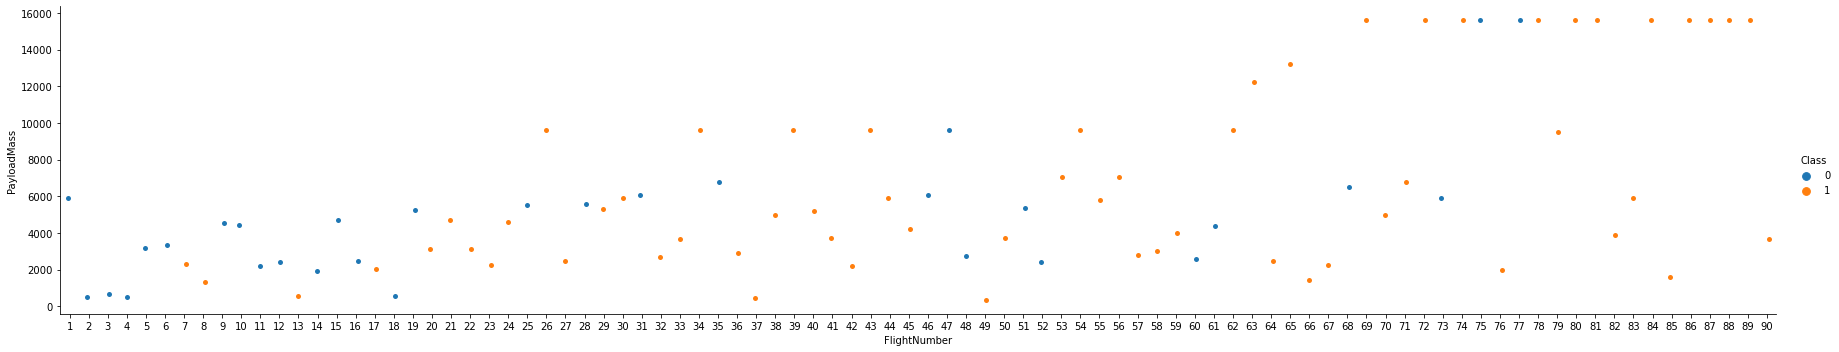

In [61]:
sns.catplot(y='PayloadMass',x='FlightNumber',data=final_9,aspect=5, hue='Class')
plt.show()

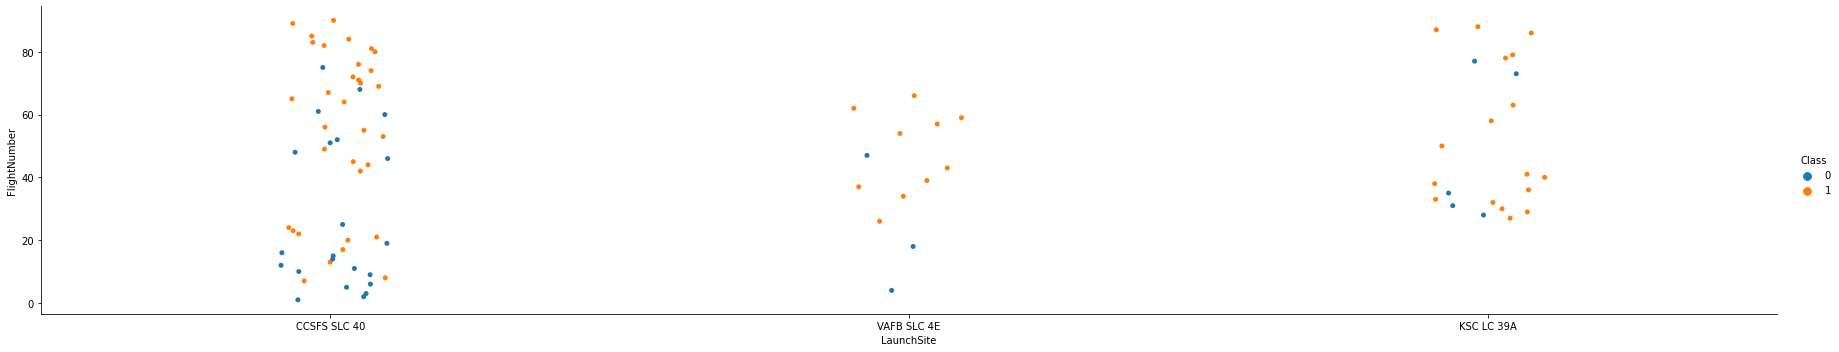

In [89]:
sns.catplot(x='LaunchSite',y='FlightNumber',data=final_9,aspect=5, hue='Class')
plt.show()

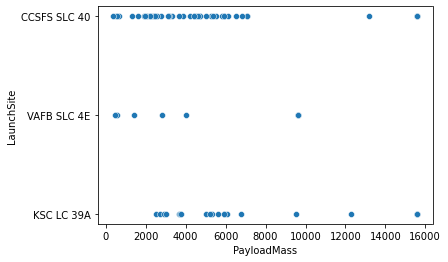

In [63]:
sns.scatterplot(y='LaunchSite',x='PayloadMass',data=final_9)
plt.show()

In [64]:
group = pd.DataFrame(final_9.groupby('Orbit').Class.mean()).reset_index()
group

,Orbit,Class
0,ES-L1,1.000000
1,GEO,1.000000
2,GTO,0.518519
3,HEO,1.000000
4,ISS,0.619048
5,LEO,0.714286
6,MEO,0.666667
7,PO,0.666667
8,SO,0.000000
9,SSO,1.000000


<AxesSubplot:xlabel='Orbit', ylabel='Class'>

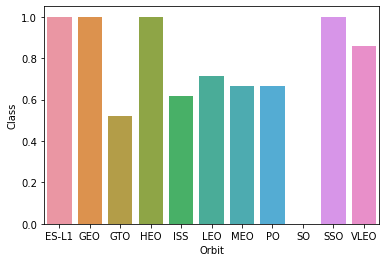

In [92]:
sns.barplot(x=group['Orbit'],y=group['Class'], data=group)

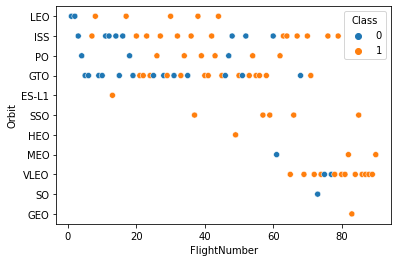

In [93]:
sns.scatterplot(y='Orbit',x='FlightNumber',data=final_9, hue='Class')
plt.show()

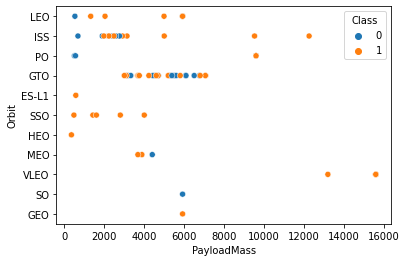

In [94]:
sns.scatterplot(y='Orbit',x='PayloadMass',data=final_9, hue = "Class")
plt.show()

/tmp/wsuser/ipykernel_164/3806520773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_9["Year"]=year


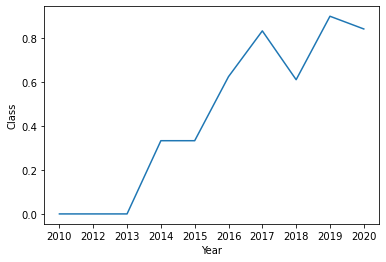

In [88]:
year = []
for i in final_9["Date"]:
    year.append(str(i).split("-")[0])

final_9["Year"]=year

group_1 = pd.DataFrame(final_9.groupby('Year').Class.mean()).reset_index()    
    
sns.lineplot(x=group_1['Year'],y=group_1['Class'], data=group_1)  
plt.show()

In [79]:
features = final_9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,5919.165341,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [80]:
features_one_hot = pd.get_dummies(features, columns=['Orbit','LaunchSite', 'LandingPad', 'Serial'])

In [81]:
features_one_hot = features_one_hot.astype('float64')
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object

In [174]:
features_one_hot.shape

(90, 80)

In [82]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

## Data Visualisation

In [85]:
import folium

In [86]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

In [87]:
spacex_df = pd.read_csv('/Users/ulric/Desktop/Ulric/DS/Excercise Files/spacex_launch_geo.csv')
spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouère cheese",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


In [117]:
launch_sites_df = spacex_df[['Launch Site','Lat','Long','class']].groupby(['Launch Site'], as_index=False).first()

In [141]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [143]:


# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )

site_map.add_child(marker)

## Model Building and Prediction

In [149]:
final_9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,5919.165341,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [151]:
X = features_one_hot

In [175]:
X.shape

(90, 80)

In [162]:
Y = final_9['Class'].values
type(Y)

numpy.ndarray

In [163]:
from sklearn.preprocessing import StandardScaler

In [164]:
X = StandardScaler().fit(X).transform(X.astype('float64'))

In [166]:
from sklearn.model_selection import train_test_split

In [177]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print('Y train size :', Y_train.shape)
print('Y test size :', Y_test.shape)
print('X train size :', X_train.shape)
print('X test size :', X_test.shape)

Y train size : (72,)
Y test size : (18,)
X train size : (72, 80)
X test size : (18, 80)


In [184]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

svm = SVC()

gscv = GridSearchCV(svm,parameters,scoring='accuracy',cv=10)
svm_cv = gscv.fit(X_train,Y_train)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


In [186]:
from sklearn.linear_model import LogisticRegression
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

gscv=GridSearchCV(lr,parameters,scoring='accuracy',cv=10)
logreg_cv=gscv.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [187]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [189]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

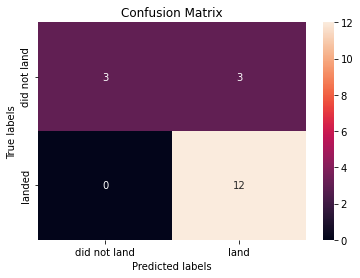

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [193]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [195]:
gscv = GridSearchCV(svm,parameters,scoring='accuracy',cv=10)
svm_cv = gscv.fit(X_train,Y_train)

In [197]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


In [198]:
svm_cv.score(X_test, Y_test)


0.8333333333333334

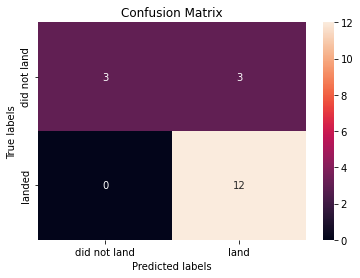

In [199]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [201]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [202]:
gst = GridSearchCV(tree,parameters,scoring='accuracy',cv=10)
tree_cv = gst.fit(X_train,Y_train)
tree_cv.best_params_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'best'}

In [203]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8607142857142858


In [204]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

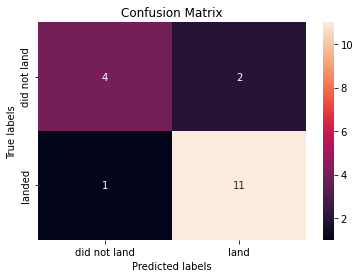

In [205]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)


In [206]:
from sklearn.neighbors import KNeighborsClassifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()


In [207]:
knngs = GridSearchCV(KNN,parameters,scoring='accuracy',cv=10)
knn_cv = knngs.fit(X_train, Y_train)

In [208]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [209]:
knn_cv.score(X_test, Y_test)


0.7777777777777778

In [211]:
yhat = KNN.predict(X_test)
plot_confusion_matrix(Y_test,yhat)


NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [212]:
print('Accuracy for Logistics Regression method:', logreg_cv.score(X_test, Y_test))
print( 'Accuracy for Support Vector Machine method:', svm_cv.score(X_test, Y_test))
print('Accuracy for Decision tree method:', tree_cv.score(X_test, Y_test))
print('Accuracy for K nearsdt neighbors method:', knn_cv.score(X_test, Y_test))

Accuracy for Logistics Regression method: 0.8333333333333334
Accuracy for Support Vector Machine method: 0.8333333333333334
Accuracy for Decision tree method: 0.8333333333333334
Accuracy for K nearsdt neighbors method: 0.7777777777777778
